# **Maze task using Q-learning**



# **Task**


---

We have a maze-like environment represented as a 2D plane with obstacles and a target point at a specific location. A robot is initially positioned at the starting point, which is (1, 1). The robot has the capability to move in four directions: up, down, left, and right.
We've developed a reinforcement learning (RL) agent that utilizes the Q-learning algorithm to learn the most efficient strategy for reaching the target. However, a new challenge has been introduced to the environment. When the robot collides with an obstacle, it becomes disoriented for a certain number of time steps (as specified in the code). During this disoriented state, it may randomly choose an action with a certain probability (also specified in the code).
This new challenge makes it challenging for the agent to learn the optimal policy based on the previous RL design. Your task is to thoroughly understand the existing code and make modifications to the RL design so that the agent can effectively learn the optimal policy even when faced with the disoriented state caused by hitting obstacles.


# **Environment**

In [47]:
from collections import deque
import random
import os
import numpy as np
import tensorflow as tf
import pandas as pd
from typing import Any
from matplotlib import pyplot as plt
from dataclasses import dataclass, field
from google.colab import drive

In [48]:
class Colors:
    RESET = "\033[0m"
    BLACK = "\u001B[40m"
    RED = "\u001B[41m"
    GREEN = "\u001B[42m"
    YELLOW = "\u001B[43m"
    BLUE = "\u001B[44m"
    PURPLE = "\u001B[45m"
    CYAN = "\u001B[46m"
    WHITE = "\u001B[47m"

In [49]:
@dataclass
class Environment:
    x: float
    y: float
    n: float
    m: float
    dizzy_state: int = field(init=False, default=0)
    mistake_probability: float = 9.0
    dizzy_state_duration: int = 8
    grid: np.ndarray = field(init=False)
    """
        cell types in the grid
        5: player
        0: empty cell
        1: obstacle
        9: target
    """

    def __post_init__(self):
        self.init_grid()

    def init_grid(self):
        self.grid = np.array([
            [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
            [1, 5, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 1],
            [1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1],
            [1, 0, 1, 1, 0, 1, 0, 0, 1, 1, 0, 1, 0, 1, 0, 0, 1],
            [1, 0, 1, 1, 0, 1, 0, 1, 1, 1, 0, 1, 0, 0, 0, 0, 1],
            [1, 0, 0, 1, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1],
            [1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1],
            [1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 1],
            [1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1],
            [1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 1],
            [1, 0, 1, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1],
            [1, 0, 1, 1, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1],
            [1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 1, 0, 0, 1],
            [1, 0, 1, 0, 1, 1, 0, 0, 1, 1, 0, 1, 0, 1, 1, 0, 1],
            [1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1],
            [1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1],
            [1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 9, 1],
            [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
            ])

    def reset(self):
        self.x = 1
        self.y = 1
        self.init_grid()
        return [self.y, self.x]

    def get_available_actions(self):
        """
            the actions in the environment are:
              0: to move right
              1: to move left
              2: to move up
              3: to move down
        """
        return 0, 1, 2, 3

    def calculate_reward(self, y, x):
        if self.grid[y][x] == 9:
            return 400
        if self.grid[y][x] == 1:
            return -10
        return -1

    def add_noise_on_action(self, action):
        if self.dizzy_state == 0:
            return action
        self.dizzy_state -= 1
        random_num = random.uniform(0, 1)
        if random_num < self.mistake_probability:
            actions = self.get_available_actions()
            return random.choice(actions)
        else:
            return action

    def is_terminal_state(self, y, x):
        return self.grid[y][x] == 9

    def move(self, y, x):
        done = self.is_terminal_state(y, x)
        next_state = None
        reward = self.calculate_reward(y, x)
        if self.dizzy_state == 0 and self.grid[y][x] == 1:
            self.dizzy_state = self.dizzy_state_duration
        if self.grid[y][x] == 9:
            next_state = [y, x]
        if self.grid[y][x] == 1:
            next_state = [self.y, self.x]
        if self.grid[y][x] == 0:
            next_state = [y, x]
        self.grid[self.y][self.x] = 0
        self.y = next_state[0]
        self.x = next_state[1]
        self.grid[self.y][self.x] = 5
        return next_state, reward, done

    def step(self, action):
        action = self.add_noise_on_action(action)
        if action == 0:
            return self.move(self.y, self.x + 1)
        if action == 1:
            return self.move(self.y, self.x - 1)
        if action == 2:
            return self.move(self.y + 1, self.x)
        if action == 3:
            return self.move(self.y - 1, self.x)

    def print_path(self, path):
        grid = np.copy(env.grid)

        for step in path[1:]:
            grid[step[0]][step[1]] = 8

        for i in range(len(grid)):
            for j in range(len(grid[0])):
                if grid[i][j] == 9:
                    print(Colors.RED, end="")
                elif grid[i][j] == 1:
                    print(Colors.GREEN, end="")
                elif grid[i][j] == 0:
                    print(Colors.RESET, end="")
                elif grid[i][j] == 5:
                    print(Colors.PURPLE, end="")
                elif grid[i][j] == 8:
                    print(Colors.YELLOW, end="")
                print("  ", end="")
            print()

# **Q-learning data**

In [50]:
env = Environment(1, 1, 17, 18)
n = 17
m = 18
# ==================================
action_size: int = len(env.get_available_actions())
state_size: int = n * m
max_steps: int = 140
num_of_episodes: int = 3000
# ==================================
epsilon: float = 1.0
epsilon_decay: float = 0.9995
epsilon_min: float = 0.01
epsilon_max: float = 1.0
gamma: float = 0.95
alpha: float = 0.01
agent_rewards = []
# ==================================
memory = []
memory_max_size: int = 2000
batch_size: int = 32
tau: float = 0.125
# ==================================
q_table = np.zeros((n, m, action_size))

# **Basic functions**

In [51]:
def get_available_actions():
    return env.get_available_actions()

def get_next_state(move):
    return env.step(action)

def reset_environment():
    return env.reset()

# **Q-learning algorithm**

In [52]:
for episode in range(num_of_episodes):
    state = reset_environment()
    episode_reward = 0
    for step in range(max_steps):
        random_num = random.uniform(0, 1)
        y = state[0]
        x = state[1]
        if random_num < epsilon:
            actions = get_available_actions()
            action = random.choice(actions)
        else:
            q_values = q_table[y, x, :]
            action = np.argmax(q_values)
        next_state, reward, done = get_next_state(action)
        next_y = next_state[0]
        next_x = next_state[1]
        q_table[y, x, action] = (1 - alpha) * q_table[y, x, action] + alpha * (reward + np.max(q_table[next_y, next_x, :]))
        episode_reward += reward
        if done:
            break
        state = next_state
    epsilon = max(epsilon_min, epsilon * epsilon_decay)
    agent_rewards.append(episode_reward)

# **Solution**

In [53]:
state = reset_environment()
episode_reward = 0
path = [state]
steps = 0
hits = 0
episode_return = 0
algorithm = 'q-learning'
for step in range(max_steps):
    y = state[0]
    x = state[1]
    action = np.argmax(q_table[y, x])
    next_state, reward, done = get_next_state(action)
    if reward == -10:
      hits += 1
    path.append(next_state)
    episode_reward += reward
    steps += 1
    if done:
        break
    state = next_state
print(episode_return)
print(steps)
print(hits)
env.print_path(path[:-1])

0
140
0
                                  
                                  
                                  
                                  
                                  
                                  
                                  
                                  
                                  
                                  
                                  
                                  
                                  
                                  
                                  
                                  
                                  
                                  


# **Plot the agent behavoir throghout training**

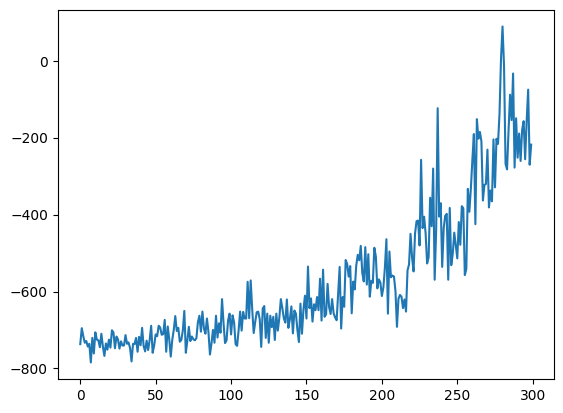

In [54]:
chunk_size = 10
y_points = np.array([])
for chunk in range(num_of_episodes // chunk_size):
    avg = np.sum(agent_rewards[chunk * chunk_size: chunk * chunk_size + chunk_size]) / chunk_size
    y_points = np.append(y_points, avg)
x_points = np.arange(0, num_of_episodes // chunk_size)
plt.plot(x_points, y_points)
# plt.savefig(f'{project_dir}/results108.png')
plt.show()

# **Solution 1**

---
Increasing Steps per Episode


In [63]:
env = Environment(1, 1, 17, 18)
n = 17
m = 18
# ==================================
action_size: int = len(env.get_available_actions())
state_size: int = n * m
max_steps: int = 200 # Modifed this line -- was 140
num_of_episodes: int = 3000
# ==================================
epsilon: float = 1.0
epsilon_decay: float = 0.9995
epsilon_min: float = 0.01
epsilon_max: float = 1.0
gamma: float = 0.95
alpha: float = 0.01
agent_rewards = []
# ==================================
memory = []
memory_max_size: int = 2000
batch_size: int = 32
tau: float = 0.125
# ==================================
q_table = np.zeros((n, m, action_size))

In [64]:
for episode in range(num_of_episodes):
    state = reset_environment()
    episode_reward = 0
    for step in range(max_steps):
        random_num = random.uniform(0, 1)
        y = state[0]
        x = state[1]
        if random_num < epsilon:
            actions = get_available_actions()
            action = random.choice(actions)
        else:
            q_values = q_table[y, x, :]
            action = np.argmax(q_values)
        next_state, reward, done = get_next_state(action)
        next_y = next_state[0]
        next_x = next_state[1]
        q_table[y, x, action] = (1 - alpha) * q_table[y, x, action] + alpha * (reward + np.max(q_table[next_y, next_x, :]))
        episode_reward += reward
        if done:
            break
        state = next_state
    epsilon = max(epsilon_min, epsilon * epsilon_decay)
    agent_rewards.append(episode_reward)

In [65]:
state = reset_environment()
episode_reward = 0
path = [state]
steps = 0
hits = 0
episode_return = 0
algorithm = 'q-learning'
for step in range(max_steps):
    y = state[0]
    x = state[1]
    action = np.argmax(q_table[y, x])
    next_state, reward, done = get_next_state(action)
    if reward == -10:
      hits += 1
    path.append(next_state)
    episode_reward += reward
    steps += 1
    if done:
        break
    state = next_state
print(episode_return)
print(steps)
print(hits)
env.print_path(path[:-1])

0
33
2
                                  
                                  
                                  
                                  
                                  
                                  
                                  
                                  
                                  
                                  
                                  
                                  
                                  
                                  
                                  
                                  
                                  
                                  


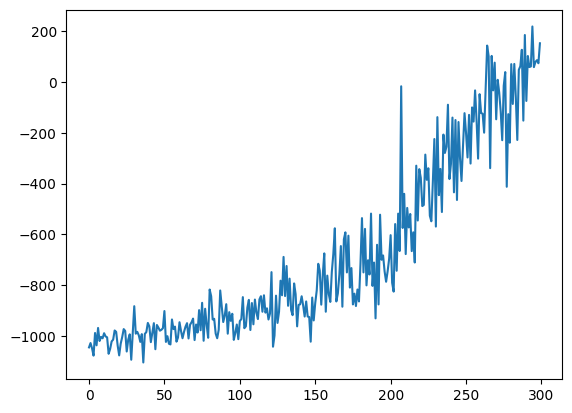

In [66]:
chunk_size = 10
y_points = np.array([])
for chunk in range(num_of_episodes // chunk_size):
    avg = np.sum(agent_rewards[chunk * chunk_size: chunk * chunk_size + chunk_size]) / chunk_size
    y_points = np.append(y_points, avg)
x_points = np.arange(0, num_of_episodes // chunk_size)
plt.plot(x_points, y_points)
plt.show()

# **Solution 2**

---
Decreasing Epsilon


In [59]:
env = Environment(1, 1, 17, 18)
n = 17
m = 18
# ==================================
action_size: int = len(env.get_available_actions())
state_size: int = n * m
max_steps: int = 140
num_of_episodes: int = 3000
# ==================================
epsilon: float = 0.5 # Modified this line -- was 1.0
epsilon_decay: float = 0.9995
epsilon_min: float = 0.01
epsilon_max: float = 1.0
gamma: float = 0.95
alpha: float = 0.01
agent_rewards = []
# ==================================
memory = []
memory_max_size: int = 2000
batch_size: int = 32
tau: float = 0.125
# ==================================
q_table = np.zeros((n, m, action_size))

In [60]:
for episode in range(num_of_episodes):
    state = reset_environment()
    episode_reward = 0
    for step in range(max_steps):
        random_num = random.uniform(0, 1)
        y = state[0]
        x = state[1]
        if random_num < epsilon:
            actions = get_available_actions()
            action = random.choice(actions)
        else:
            q_values = q_table[y, x, :]
            action = np.argmax(q_values)
        next_state, reward, done = get_next_state(action)
        next_y = next_state[0]
        next_x = next_state[1]
        q_table[y, x, action] = (1 - alpha) * q_table[y, x, action] + alpha * (reward + np.max(q_table[next_y, next_x, :]))
        episode_reward += reward
        if done:
            break
        state = next_state
    epsilon = max(epsilon_min, epsilon * epsilon_decay)
    agent_rewards.append(episode_reward)

In [61]:
state = reset_environment()
episode_reward = 0
path = [state]
steps = 0
hits = 0
episode_return = 0
algorithm = 'q-learning'
for step in range(max_steps):
    y = state[0]
    x = state[1]
    action = np.argmax(q_table[y, x])
    next_state, reward, done = get_next_state(action)
    if reward == -10:
      hits += 1
    path.append(next_state)
    episode_reward += reward
    steps += 1
    if done:
        break
    state = next_state
print(episode_return)
print(steps)
print(hits)
env.print_path(path[:-1])

0
29
0
                                  
                                  
                                  
                                  
                                  
                                  
                                  
                                  
                                  
                                  
                                  
                                  
                                  
                                  
                                  
                                  
                                  
                                  


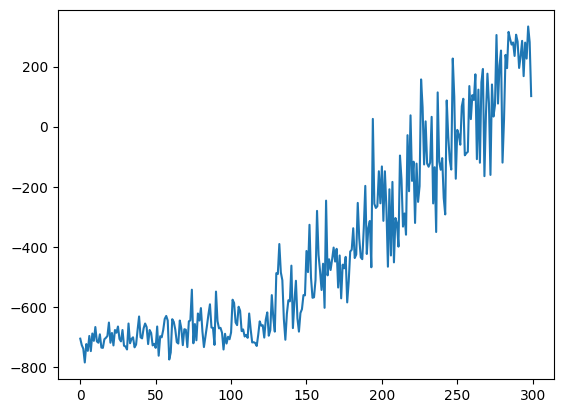

In [62]:
chunk_size = 10
y_points = np.array([])
for chunk in range(num_of_episodes // chunk_size):
    avg = np.sum(agent_rewards[chunk * chunk_size: chunk * chunk_size + chunk_size]) / chunk_size
    y_points = np.append(y_points, avg)
x_points = np.arange(0, num_of_episodes // chunk_size)
plt.plot(x_points, y_points)
plt.show()

# **Solution 3**

---
Decreasing Epsilon Decay


In [67]:
env = Environment(1, 1, 17, 18)
n = 17
m = 18
# ==================================
action_size: int = len(env.get_available_actions())
state_size: int = n * m
max_steps: int = 140
num_of_episodes: int = 3000
# ==================================
epsilon: float = 1.0
epsilon_decay: float = 0.8 # Modified this line -- was 0.9995
epsilon_min: float = 0.01
epsilon_max: float = 1.0
gamma: float = 0.95
alpha: float = 0.01
agent_rewards = []
# ==================================
memory = []
memory_max_size: int = 2000
batch_size: int = 32
tau: float = 0.125
# ==================================
q_table = np.zeros((n, m, action_size))

In [68]:
for episode in range(num_of_episodes):
    state = reset_environment()
    episode_reward = 0
    for step in range(max_steps):
        random_num = random.uniform(0, 1)
        y = state[0]
        x = state[1]
        if random_num < epsilon:
            actions = get_available_actions()
            action = random.choice(actions)
        else:
            q_values = q_table[y, x, :]
            action = np.argmax(q_values)
        next_state, reward, done = get_next_state(action)
        next_y = next_state[0]
        next_x = next_state[1]
        q_table[y, x, action] = (1 - alpha) * q_table[y, x, action] + alpha * (reward + np.max(q_table[next_y, next_x, :]))
        episode_reward += reward
        if done:
            break
        state = next_state
    epsilon = max(epsilon_min, epsilon * epsilon_decay)
    agent_rewards.append(episode_reward)

In [69]:
state = reset_environment()
episode_reward = 0
path = [state]
steps = 0
hits = 0
episode_return = 0
algorithm = 'q-learning'
for step in range(max_steps):
    y = state[0]
    x = state[1]
    action = np.argmax(q_table[y, x])
    next_state, reward, done = get_next_state(action)
    if reward == -10:
      hits += 1
    path.append(next_state)
    episode_reward += reward
    steps += 1
    if done:
        break
    state = next_state
print(episode_return)
print(steps)
print(hits)
env.print_path(path[:-1])

0
29
0
                                  
                                  
                                  
                                  
                                  
                                  
                                  
                                  
                                  
                                  
                                  
                                  
                                  
                                  
                                  
                                  
                                  
                                  


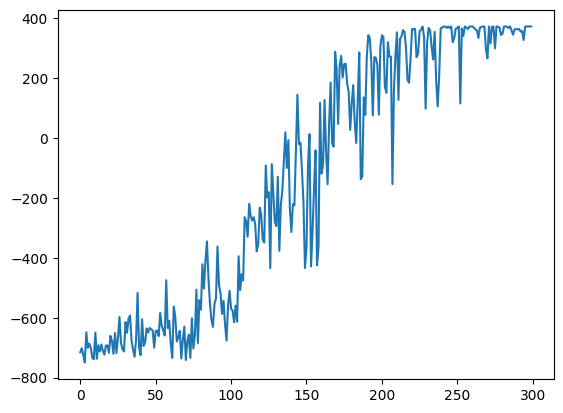

In [70]:
chunk_size = 10
y_points = np.array([])
for chunk in range(num_of_episodes // chunk_size):
    avg = np.sum(agent_rewards[chunk * chunk_size: chunk * chunk_size + chunk_size]) / chunk_size
    y_points = np.append(y_points, avg)
x_points = np.arange(0, num_of_episodes // chunk_size)
plt.plot(x_points, y_points)
plt.show()